In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = Path('data/bulldozers')

In [4]:
!ls {PATH}

 bluebook-for-bulldozers.zip	    Test.csv	        Train.zip
'Data Dictionary.xlsx'		    Train.7z	        Valid.7z
 df_raw_before_imputation	    TrainAndValid.7z    Valid.csv
 Machine_Appendix.csv		    TrainAndValid.csv   ValidSolution.csv
 median_benchmark.csv		    TrainAndValid.zip   Valid.zip
 random_forest_benchmark_test.csv   Train.csv


In [5]:
def display_all(df):
    h = df.shape[0]
    w = 1 if len(df.shape) == 1 else df.shape[1]
    with pd.option_context("display.max_rows", h, "display.max_columns", w): 
        display(df)

### Load data

In [6]:
df_raw = pd.read_csv(PATH/'Train.csv', parse_dates=['saledate'], 
                     low_memory=False)

In [7]:
display_all(df_raw.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [8]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaT,NaT,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaT,NaT,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaT,NaT,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaT,NaT,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaT,NaT,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaT,NaT,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaT,NaT,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaT,NaT,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17,2011-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Take log of sales price since metric is root mean square log error

In [9]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### Format date and convert strings to categories

In [10]:
add_datepart(df_raw, 'saledate')

In [11]:
display_all(df_raw.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,11.0974,10.9508,9.21034,10.5584,9.30565
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175


In [12]:
train_cats(df_raw)

### We can try to find ordinals and order them

In [13]:
for c in df_raw.columns:
    if df_raw[c].dtype.name == 'category':
        print(f'{c} has the following categories: {df_raw[c].cat.categories}')

UsageBand has the following categories: Index(['High', 'Low', 'Medium'], dtype='object')
fiModelDesc has the following categories: Index(['100C', '104', '1066', '1066E', '1080', '1080B', '1088', '1088CK',
       '1088LT', '1088TTL',
       ...
       'ZX600LC', 'ZX70', 'ZX75', 'ZX75US', 'ZX75USA', 'ZX80', 'ZX800',
       'ZX800LC', 'ZX80LCK', 'ZX850H'],
      dtype='object', length=4999)
fiBaseModel has the following categories: Index(['10', '100', '104', '1066', '1080', '1088', '10DG', '11', '110', '1105',
       ...
       'ZX370', 'ZX450', 'ZX460', 'ZX50', 'ZX600', 'ZX70', 'ZX75', 'ZX80',
       'ZX800', 'ZX850'],
      dtype='object', length=1950)
fiSecondaryDesc has the following categories: Index([' MSR SPIN ACE', '#NAME?', '-2', '-3', '-5', '-5L', '-6', '-7', '0.7',
       '1',
       ...
       'XP', 'XT', 'Z', 'ZF', 'ZHS', 'ZHS G', 'ZT', 'ZTM', 'ZTS', 'ZX'],
      dtype='object', length=175)
fiModelSeries has the following categories: Index([' III', '#NAME?', '-1', '-1.50E+01'

### There seems to be some ordinals but lets just format UsageBand for now

In [14]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [15]:
for l in zip(df_raw.UsageBand[0:5], df_raw.UsageBand[0:5].cat.codes):
    print(l)

('Low', 1)
('Low', 1)
('High', 0)
('High', 0)
('Medium', 2)


In [16]:
df_raw.UsageBand.cat.reorder_categories(['High', 'Medium', 'Low'], ordered=True,
                                        inplace=True)

In [17]:
df_raw.UsageBand.cat.categories

Index(['High', 'Medium', 'Low'], dtype='object')

In [18]:
for l in zip(df_raw.UsageBand[0:5], df_raw.UsageBand[0:5].cat.codes):
    print(l)

('Low', 2)
('Low', 2)
('High', 0)
('High', 0)
('Medium', 1)


In [19]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

### Handle missing values

In [20]:
for r in zip(df_raw.columns,
             df_raw.isnull().sum(), 
             [df_raw[c].dtype.name for c in df_raw.columns]):
    if r[1] > 0:
        print(r)

('auctioneerID', 20136, 'float64')
('MachineHoursCurrentMeter', 258360, 'float64')
('fiSecondaryDesc', 137191, 'category')
('fiModelSeries', 344217, 'category')
('fiModelDescriptor', 329206, 'category')
('ProductSize', 210775, 'category')
('Drive_System', 296764, 'category')
('Enclosure', 325, 'category')
('Forks', 209048, 'category')
('Pad_Type', 321991, 'category')
('Ride_Control', 252519, 'category')
('Stick', 321991, 'category')
('Transmission', 217895, 'category')
('Turbocharged', 321991, 'category')
('Blade_Extension', 375906, 'category')
('Blade_Width', 375906, 'category')
('Enclosure_Type', 375906, 'category')
('Engine_Horsepower', 375906, 'category')
('Hydraulics', 80555, 'category')
('Pushblock', 375906, 'category')
('Ripper', 296988, 'category')
('Scarifier', 375895, 'category')
('Tip_Control', 375906, 'category')
('Tire_Size', 306407, 'category')
('Coupler', 187173, 'category')
('Coupler_System', 357667, 'category')
('Grouser_Tracks', 357763, 'category')
('Hydraulics_Flow',

### Save df_raw before we impute missing values

In [21]:
df_raw.to_feather(PATH/'df_raw_before_imputation')

### Now Handle missing values

In [22]:
df_raw = pd.read_feather(PATH/'df_raw_before_imputation')

In [23]:
x, y, nas = proc_df(df_raw, 'SalePrice')

In [24]:
nas

{'auctioneerID': 2.0, 'MachineHoursCurrentMeter': 0.0}

In [25]:
# This is correct, as auctioneerID and MachineHoursCurrentMeter are the
# only non-categorical columns with missing values

In [26]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(x, y)
m.score(x,y)

/home/justin/venv/fastai_ml1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9831942729388822

### Need to create a validation set to get a better indication of score

In [27]:
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()

In [28]:
n_valid = 12000
n_train = df_raw.shape[0] - n_valid
df_raw_train, df_raw_val = split_vals(df_raw, n_train)
df_raw_train.shape, df_raw_val.shape

((389125, 65), (12000, 65))

In [29]:
x_train, y_train, nas = proc_df(df_raw_train, 'SalePrice')

In [30]:
x_val, y_val, _ = proc_df(df_raw_val, 'SalePrice', na_dict=nas)

### Print scores function

In [31]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m, x_train, y_train, x_val, y_val):
    print(f'Train rmse: {rmse(m.predict(x_train), y_train)}')
    print(f'Val rmse:   {rmse(m.predict(x_val), y_val)}')
    print(f'Train R^2:  {m.score(x_train, y_train)}')
    print(f'Val R^2:    {m.score(x_val, y_val)}')
    if hasattr(m, 'oob_score_'): print(f'OOB score:  {m.oob_score_}')

### Train again

In [32]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

/home/justin/venv/fastai_ml1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 20s, sys: 229 ms, total: 1min 20s
Wall time: 9.47 s
Train rmse: 0.09079565107956535
Val rmse:   0.25286923545472073
Train R^2:  0.982770807611528
Val R^2:    0.8858068731711146


### For testing purposes, lets grab a subset of data for the training set

In [33]:
idx = np.random.choice(x_train.shape[0], 
                       20_000, 
                       replace=False)
idx.sort()

In [34]:
x_train_sub = x_train.iloc[idx]
y_train_sub = y_train[idx]

In [35]:
x_train_sub.shape, y_train_sub.shape

((20000, 66), (20000,))

In [36]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(x_train_sub, y_train_sub)
print_score(m, x_train_sub, y_train_sub, x_val, y_val)

/home/justin/venv/fastai_ml1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 3.2 s, sys: 242 µs, total: 3.2 s
Wall time: 442 ms
Train rmse: 0.11683811213909447
Val rmse:   0.2962603493044329
Train R^2:  0.9714302401776913
Val R^2:    0.8432545167631298


### Try a single tree

In [37]:
m = RandomForestRegressor(n_estimators=1, 
                          max_depth=3, 
                          bootstrap=False,
                          n_jobs=-1)
m.fit(x_train_sub, y_train_sub)
print_score(m, x_train_sub, y_train_sub, x_val, y_val)

Train rmse: 0.5324994750722738
Val rmse:   0.5683840862750552
Train R^2:  0.4065612581070952
Val R^2:    0.4230584806218316


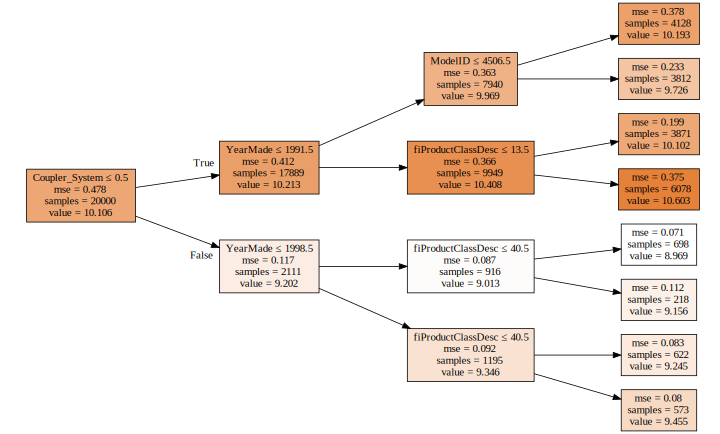

In [38]:
draw_tree(m.estimators_[0], x_train_sub, precision=3)

In [39]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(x_train_sub, y_train_sub)
print_score(m, x_train_sub, y_train_sub, x_val, y_val)

Train rmse: 4.864753555590494e-17
Val rmse:   0.400966689388831
Train R^2:  1.0
Val R^2:    0.7128792607272751


### Bagging

In [40]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(x_train_sub, y_train_sub)
print_score(m, x_train_sub, y_train_sub, x_val, y_val)

/home/justin/venv/fastai_ml1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train rmse: 0.11579282330834993
Val rmse:   0.2957875625005628
Train R^2:  0.9719391505519804
Val R^2:    0.8437544018423475


In [41]:
preds = np.stack([t.predict(x_val) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_val[0]

(array([9.21034, 9.21034, 9.43348, 9.21034, 9.25913, 9.41328, 9.21034, 9.25913, 9.51044, 9.41328]),
 9.313011387985863,
 9.104979856318357)

In [42]:
preds.shape

(10, 12000)

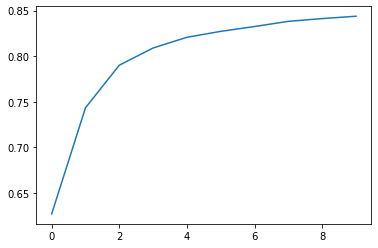

In [43]:
plt.plot([metrics.r2_score(y_val, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [44]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(x_train_sub, y_train_sub)
print_score(m, x_train_sub, y_train_sub, x_val, y_val)

Train rmse: 0.1062342852856144
Val rmse:   0.2895331775936786
Train R^2:  0.9763807051248418
Val R^2:    0.8502921244855061


In [45]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(x_train_sub, y_train_sub)
print_score(m, x_train_sub, y_train_sub, x_val, y_val)

Train rmse: 0.10033366622353646
Val rmse:   0.284569268536584
Train R^2:  0.9789316322269818
Val R^2:    0.8553814612290306


In [46]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(x_train_sub, y_train_sub)
print_score(m, x_train_sub, y_train_sub, x_val, y_val)

Train rmse: 0.09709965718208831
Val rmse:   0.2813670090785948
Train R^2:  0.9802679175952892
Val R^2:    0.8586179345022356


### Try using out of bag scoring

In [47]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(x_train_sub, y_train_sub)
print_score(m, x_train_sub, y_train_sub, x_val, y_val)

Train rmse: 0.10005626939648736
Val rmse:   0.28518010046018905
Train R^2:  0.979047968439915
Val R^2:    0.8547599434548084
OOB score:  0.8491656927727618


### Use rf samples instead of subsampling training set from the beginning

In [48]:
set_rf_samples(20000)

In [49]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

/home/justin/venv/fastai_ml1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 7.55 s, sys: 188 ms, total: 7.74 s
Wall time: 2.25 s
Train rmse: 0.24078792431879903
Val rmse:   0.275499758336112
Train R^2:  0.8788274543041337
Val R^2:    0.8644528413020107
OOB score:  0.8662703353162576


In [50]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

Train rmse: 0.22719757938976617
Val rmse:   0.2611061208419364
Train R^2:  0.8921196799804396
Val R^2:    0.8782463248526604
OOB score:  0.8806346590290944


### Tree building parameters

In [54]:
reset_rf_samples()

In [55]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)


In [56]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

Train rmse: 0.0783216253867601
Val rmse:   0.23677205167217263
Train R^2:  0.9871796993657049
Val R^2:    0.899882764567293
OOB score:  0.9086316454118213


In [57]:
t=m.estimators_[0].tree_

In [58]:
dectree_max_depth(t)

48

In [59]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

Train rmse: 0.1407967626400923
Val rmse:   0.2348736695541341
Train R^2:  0.9585695009759843
Val R^2:    0.9014817610455047
OOB score:  0.906919200860248


In [60]:
t=m.estimators_[0].tree_

In [61]:
dectree_max_depth(t)

37

In [62]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

Train rmse: 0.11494833461487029
Val rmse:   0.23311485105917598
Train R^2:  0.9723853086689982
Val R^2:    0.9029517165812967
OOB score:  0.9086137302533694


In [63]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

Train rmse: 0.11909826191743786
Val rmse:   0.22747231493919962
Train R^2:  0.9703553946398882
Val R^2:    0.9075929579465105
OOB score:  0.9116905730874449


In [64]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m, x_train, y_train, x_val, y_val)

Train rmse: 0.11784417282263504
Val rmse:   0.22706051233375424
Train R^2:  0.9709764153224999
Val R^2:    0.9079272317310537
OOB score:  0.9146514271276055
